Imports

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import editdistance
import cv2

Load the data

In [2]:
! wget https://www.orand.cl/orand_car/ORAND-CAR-2014.tar.gz

--2024-07-29 06:59:30--  https://www.orand.cl/orand_car/ORAND-CAR-2014.tar.gz
Resolving www.orand.cl (www.orand.cl)... 162.241.225.60
Connecting to www.orand.cl (www.orand.cl)|162.241.225.60|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203530245 (194M) [application/x-gzip]
Saving to: ‘ORAND-CAR-2014.tar.gz’

ORAND-CAR-2014.tar. 100%[===================>] 194.10M  62.8MB/s    in 3.1s    

2024-07-29 06:59:34 (62.8 MB/s) - ‘ORAND-CAR-2014.tar.gz’ saved [203530245/203530245]



In [3]:
!tar -xzf ORAND-CAR-2014.tar.gz

In [3]:
path_list = []
labels_list = []

In [4]:
with open('ORAND-CAR-2014/CAR-A/a_train_gt.txt', 'r') as file:
  for line in file:
    a, b = line.strip().split('\t')
    path_list.append('ORAND-CAR-2014/CAR-A/a_train_images/'+a)
    labels_list.append(b)

In [5]:
with open('ORAND-CAR-2014/CAR-A/a_test_gt.txt', 'r') as file:
  for line in file:
    a, b = line.strip().split('\t')
    path_list.append('ORAND-CAR-2014/CAR-A/a_test_images/'+a)
    labels_list.append(b)

In [6]:
with open('ORAND-CAR-2014/CAR-B/b_train_gt.txt', 'r') as file:
  for line in file:
    a, b = line.strip().split('\t')
    path_list.append('ORAND-CAR-2014/CAR-B/b_train_images/'+a)
    labels_list.append(b)

In [7]:
with open('ORAND-CAR-2014/CAR-B/b_test_gt.txt', 'r') as file:
  for line in file:
    a, b = line.strip().split('\t')
    path_list.append('ORAND-CAR-2014/CAR-B/b_test_images/'+a)
    labels_list.append(b)

In [8]:
len(path_list)

11719

In [9]:
characters = set(char for label in labels_list for char in label)
characters = sorted(list(characters))
characters

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [10]:
max_length = max([len(label) for label in labels_list])
max_length

8

Preprocessing

In [11]:
# Mapping characters to integers
char_to_num = layers.StringLookup(
    vocabulary=list(characters), mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


def split_data(images, labels, train_size=0.8, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    np.random.seed(42)
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    val_test_size = (size - train_samples) // 2
    # 4. Split data into training and validation and test sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:train_samples+val_test_size]], labels[indices[train_samples:train_samples+val_test_size]]
    x_test, y_test = images[indices[train_samples+val_test_size:]], labels[indices[train_samples+val_test_size:]]
    return x_train, x_valid, x_test, y_train, y_valid, y_test


# Splitting data into training and validation and test sets
x_train, x_valid, x_test, y_train, y_valid, y_test = split_data(np.array(path_list), np.array(labels_list))


In [12]:
# Batch size for training and validation and test
batch_size = 16

# Desired image dimensions
img_height = 50
padding_token = 11

In [13]:
def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, tf.shape(img)[1]])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_length - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    # 7. Return a dict as our model is expecting two inputs
    return img, label

Create Dataset objects

In [14]:
padded_shapes = ([None, None, 1], [None])  # Shape of images and labels
padding_values = (0.0, np.int64(0))  # Padding values for images and labels

def map_fn(image, label):
    return {'image': image, 'label': label}

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .padded_batch(batch_size, padded_shapes=padded_shapes, padding_values=padding_values)
    .map(map_fn, num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
    .cache()
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .padded_batch(batch_size, padded_shapes=padded_shapes, padding_values=padding_values)
    .map(map_fn, num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
    .cache()
)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = (
    test_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .padded_batch(batch_size, padded_shapes=padded_shapes, padding_values=padding_values)
    .map(map_fn, num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

Visualize the data

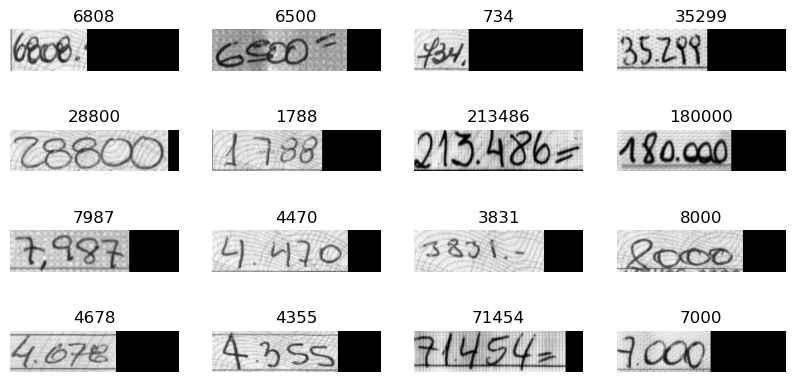

In [15]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8").replace('[UNK]','')
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

Model

In [16]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred


def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(None, 50, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        64,
        (5, 5),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        128,
        (5, 5),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 128. Reshape accordingly before
    # passing the output to the RNN part of the model
    x = layers.Reshape(target_shape=(-1, (img_height//4)*128), name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.4))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.4))(x)

    # Output layer
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt,)
    return model


# Get the model
model = build_model()
model.summary()

Model: "ocr_model_v1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)            │ (None, None, 50, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, None, 50, 64)      │           1,664 │ image[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1 (MaxPooling2D)          │ (None, None, 25, 64)      │               0 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv2 (Conv2D)                │ (None, None, 25, 128)     │         204,928 │ pool1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool2 (MaxPooling2D)          │ (None, None, 12, 128)     │               0 │ Conv2[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape (Reshape)             │ (None, None, 1536)        │               0 │ pool2[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense1 (Dense)                │ (None, None, 64)          │          98,368 │ reshape[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, None, 64)          │               0 │ dense1[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional (Bidirectional) │ (None, None, 256)         │         197,632 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional_1               │ (None, None, 128)         │         164,352 │ bidirectional[0][0]        │
│ (Bidirectional)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ label (InputLayer)            │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense2 (Dense)                │ (None, None, 12)          │           1,548 │ bidirectional_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ ctc_loss (CTCLayer)           │ (None, None, 12)          │               0 │ label[0][0], dense2[0][0]  │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 668,492 (2.55 MB)

 Trainable params: 668,492 (2.55 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
model.load_weights('weight_multi_digit_padded.h5')

Custom Callback

In [ ]:
class CERCallback(keras.callbacks.Callback):
    def __init__(self, train_data, val_data, num_to_char):
        # Initialize the callback with training data, validation data, and a mapping from numbers to characters
        self.train_data = train_data
        self.val_data = val_data
        self.num_to_char = num_to_char

    def decode_batch_predictions(self, pred):
        # Decode the batch predictions into readable text
        input_len = np.ones(pred.shape[0]) * pred.shape[1]
        results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :max_length]
        output_text = []
        for res in results:
            res = tf.strings.reduce_join(self.num_to_char(res)).numpy().decode("utf-8")
            output_text.append(res)
        return output_text

    def calculate_cer(self, y_true, y_pred):
        # Calculate the Character Error Rate (CER) between true and predicted sequences
        sum_distance = 0
        sum_length = 0
        for true_seq, pred_seq in zip(y_true, y_pred):
            sum_distance = sum_distance + editdistance.eval(true_seq, pred_seq)
            sum_length = sum_length + len(true_seq)
        return sum_distance / sum_length

    def on_epoch_end(self, epoch, logs=None):
        # Called at the end of each epoch to calculate the CER on the validation data
        prediction_model = keras.models.Model(
              self.model.get_layer(name="image").input, self.model.get_layer(name="dense2").output
                    )
        # Validation data
        val_pred_texts = []
        val_orig_texts = []
        for batch in self.val_data:
            batch_images = batch["image"]
            batch_labels = batch["label"]

            # Predict the text for the batch images
            preds = prediction_model.predict(batch_images, verbose=0)
            pred_texts = self.decode_batch_predictions(preds)
            val_pred_texts.extend(pred_texts)

            # Get the original text from the labels
            orig_texts = []
            for label in batch_labels:
                label = tf.strings.reduce_join(self.num_to_char(label)).numpy().decode("utf-8")
                orig_texts.append(label)
            val_orig_texts.extend(orig_texts)

        # Remove any [UNK] tokens from the predictions and original texts
        val_pred_texts = [s.replace('[UNK]', '') for s in val_pred_texts]
        val_orig_texts = [s.replace('[UNK]', '') for s in val_orig_texts]

        # Calculate the CER for the validation data
        val_cer = self.calculate_cer(val_orig_texts, val_pred_texts)

        print(f" Validation CER: {val_cer:.4f}")

In [ ]:
cer_callback = CERCallback(train_data=train_dataset, val_data=validation_dataset, num_to_char=num_to_char)

In [ ]:
tensorboard_callback = keras.callbacks.TensorBoard(log_dir="./logs")
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1,
                              patience=2, min_lr=0.000001)

Training

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=50,
    callbacks=[reduce_lr, tensorboard_callback, cer_callback],
)

Epoch 1/50
586/586 [==============================] - 148s 229ms/step - loss: 12.4923 - val_loss: 12.7008 - lr: 0.0010
Epoch 2/50
586/586 [==============================] - 31s 53ms/step - loss: 11.5027 - val_loss: 11.5570 - lr: 0.0010
Epoch 3/50
586/586 [==============================] - 31s 53ms/step - loss: 11.4679 - val_loss: 11.3433 - lr: 0.0010
Epoch 4/50
586/586 [==============================] - 31s 53ms/step - loss: 10.4646 - val_loss: 7.4124 - lr: 0.0010
Epoch 5/50
586/586 [==============================] - 31s 52ms/step - loss: 4.1766 - val_loss: 1.4272 - lr: 0.0010
Epoch 6/50
586/586 [==============================] - 32s 55ms/step - loss: 1.7013 - val_loss: 0.8751 - lr: 0.0010
Epoch 7/50
586/586 [==============================] - 31s 52ms/step - loss: 1.2598 - val_loss: 0.7239 - lr: 0.0010
Epoch 8/50
586/586 [==============================] - 31s 53ms/step - loss: 1.0222 - val_loss: 0.6091 - lr: 0.0010
Epoch 9/50
586/586 [==============================] - 30s 52ms/step - l

Prediction

In [22]:
prediction_model = keras.models.Model(
    model.inputs[0], model.get_layer(name="dense2").output
)

In [23]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :max_length]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8").replace('[UNK]','')
        output_text.append(res)
    return output_text

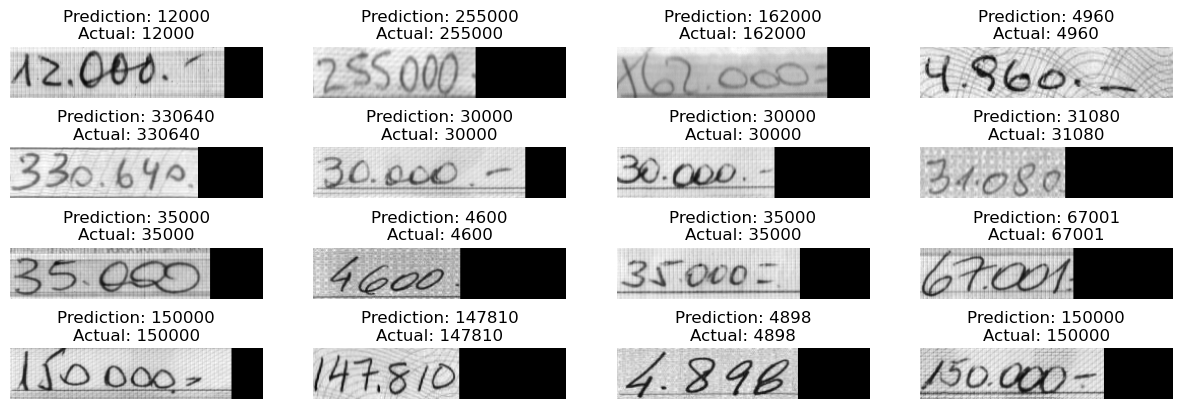

In [24]:
#  Let's check results on some test samples
for batch in test_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images, verbose=0)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8").replace('[UNK]','')
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}\nActual: {orig_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

Analysis

In [34]:
pred_list = []
orig_list = []
misclassified_images = []
orig_char_count = {}
error_char_count = {}

def update_char_count(dictionary, char):
    if char in dictionary:
        dictionary[char] += 1
    else:
        dictionary[char] = 1
        

for batch in test_dataset.take(74):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    # Predict the text for the batch images using the prediction model
    preds = prediction_model.predict(batch_images, verbose=0)
    # Decode the batch predictions into readable text
    pred_texts = decode_batch_predictions(preds)
    pred_list = pred_list + pred_texts

    orig_texts = []
    for label in batch_labels:
        # Convert the numerical labels to text
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8").replace('[UNK]','')
        orig_texts.append(label)
    orig_list = orig_list + orig_texts

    for img, pred_text, orig_text in zip(batch_images, pred_texts, orig_texts):
        if pred_text != orig_text:
            misclassified_images.append((img, orig_text, pred_text))
            
        for orig_char, pred_char in zip(orig_text, pred_text):
            update_char_count(orig_char_count, orig_char)
            if orig_char != pred_char:
                update_char_count(error_char_count, orig_char)
                
                
char_error_ratio = {char: error_char_count.get(char, 0) / orig_char_count[char] for char in orig_char_count}

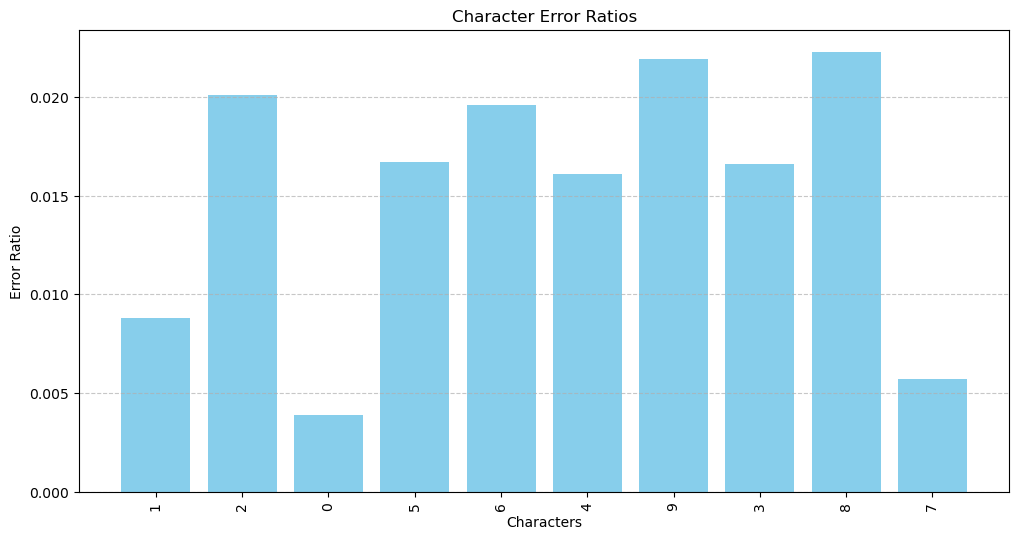

In [32]:
chars = list(char_error_ratio.keys())
error_ratios = list(char_error_ratio.values())

plt.figure(figsize=(12, 6))
plt.bar(chars, error_ratios, color='skyblue')

plt.xlabel('Characters')
plt.ylabel('Error Ratio')
plt.title('Character Error Ratios')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


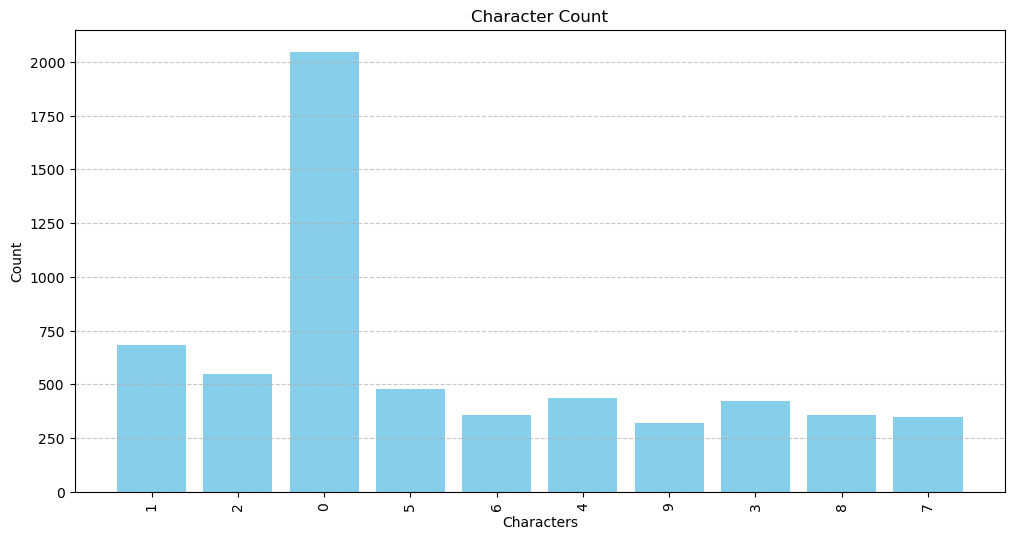

In [39]:
chars = list(orig_char_count.keys())
error_ratios = list(orig_char_count.values())

plt.figure(figsize=(12, 6))
plt.bar(chars, error_ratios, color='skyblue')

plt.xlabel('Characters')
plt.ylabel('Count')
plt.title('Character Count')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


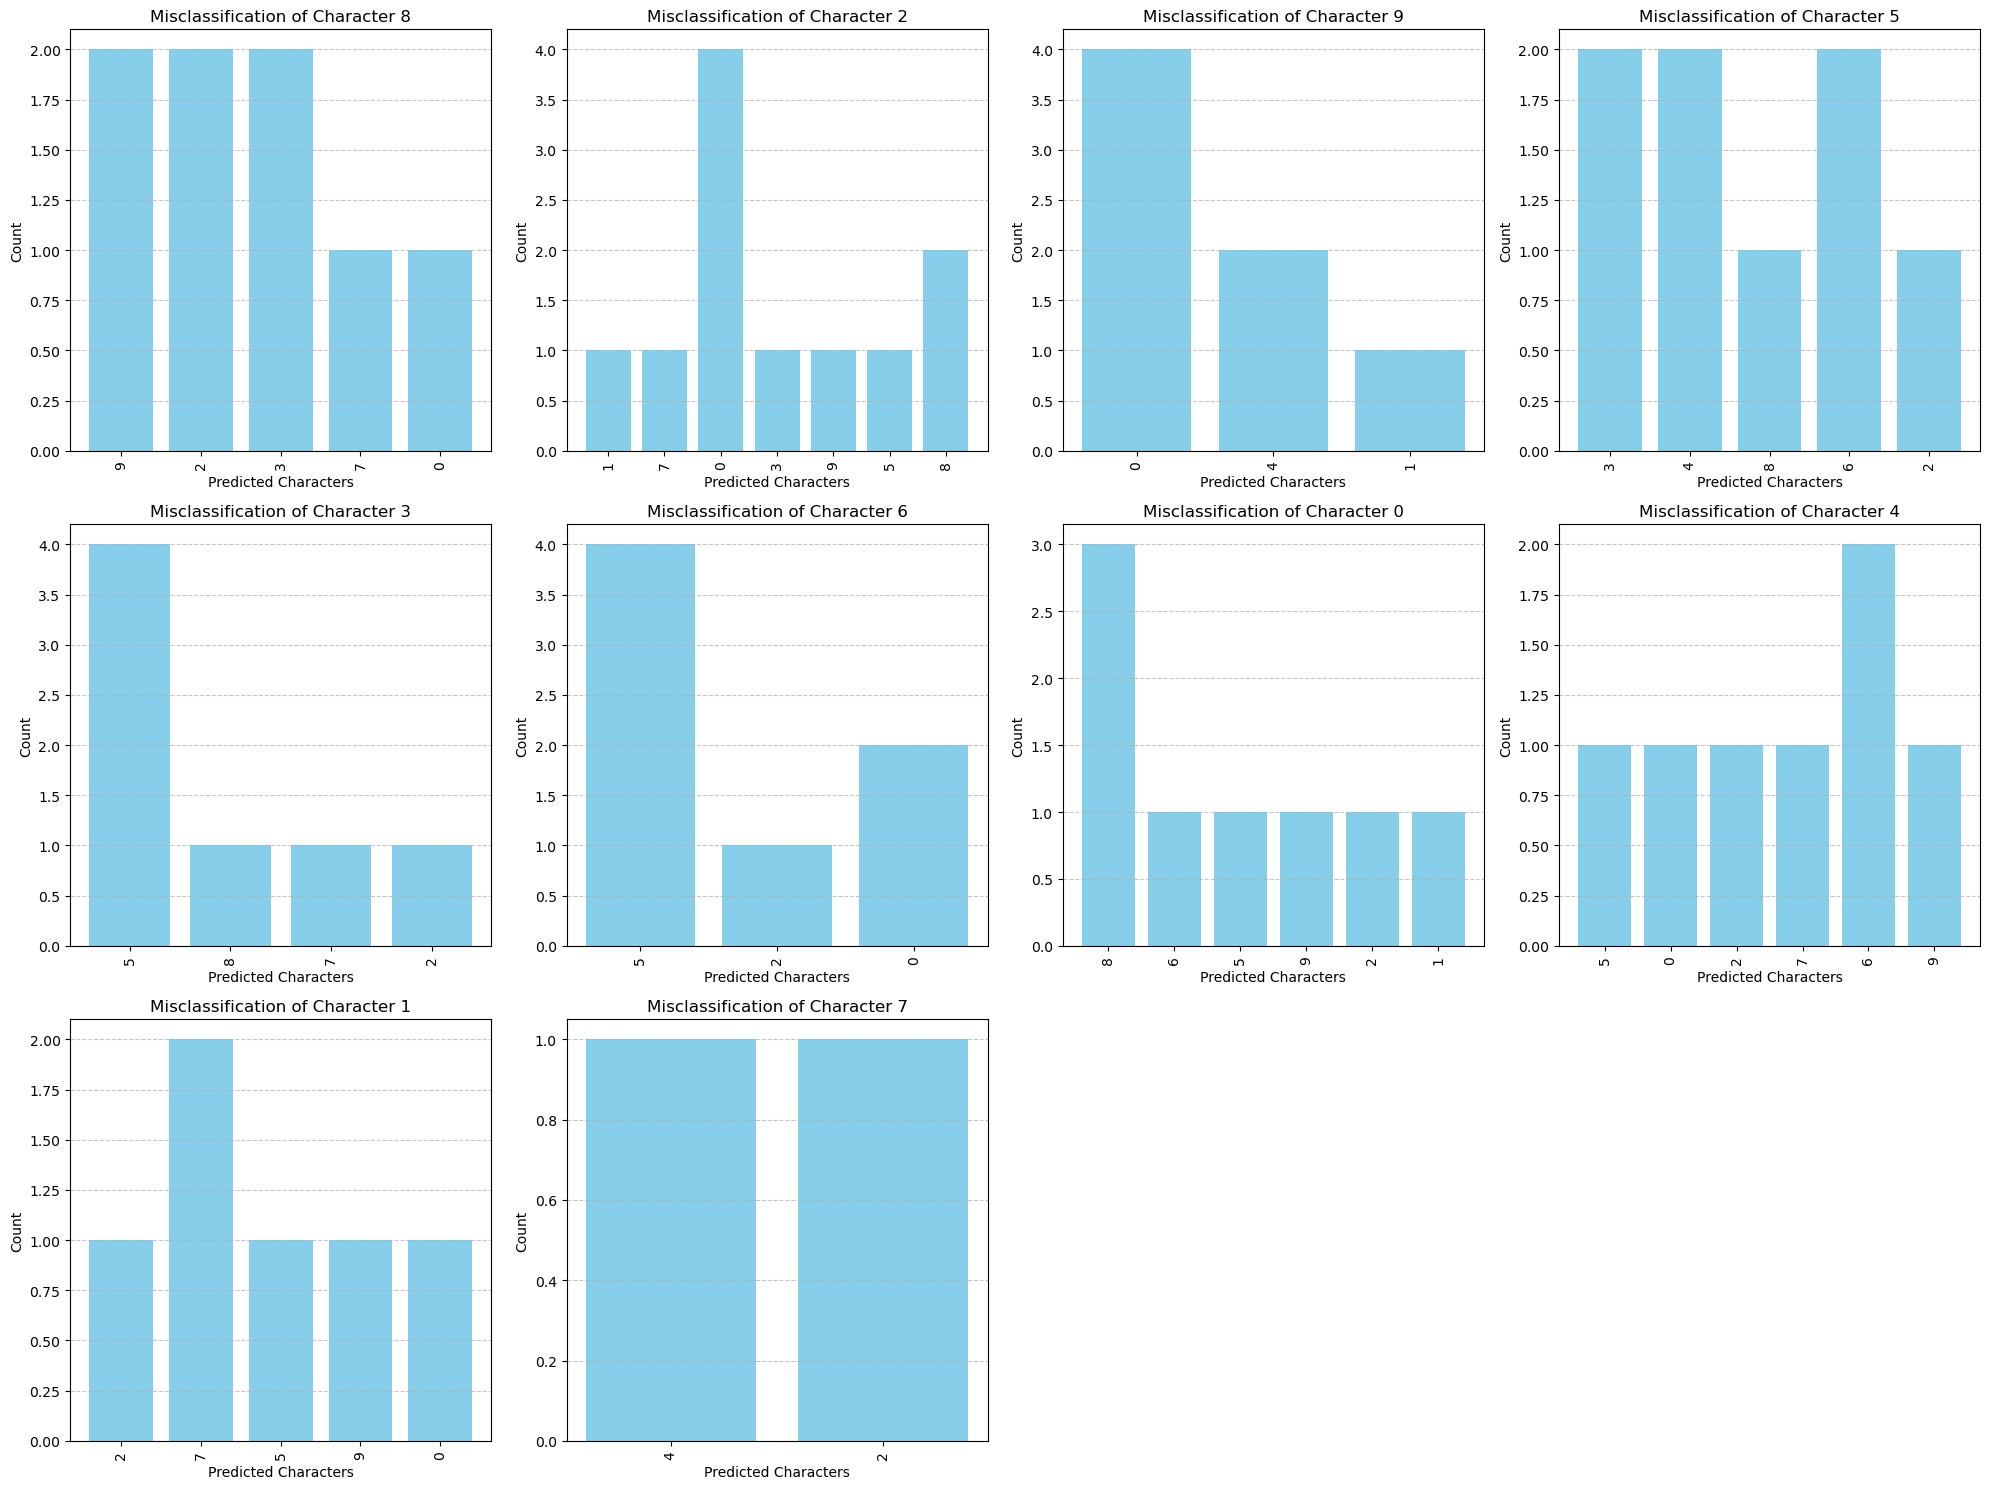

In [38]:
pred_list = []
orig_list = []
misclassified_images = []
misclassification_count = {}

def update_misclassification_count(dictionary, orig_char, pred_char):
    if orig_char not in dictionary:
        dictionary[orig_char] = {}
    if pred_char in dictionary[orig_char]:
        dictionary[orig_char][pred_char] += 1
    else:
        dictionary[orig_char][pred_char] = 1

for batch in test_dataset.take(74):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images, verbose=0)
    pred_texts = decode_batch_predictions(preds)
    pred_list.extend(pred_texts)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8").replace('[UNK]','')
        orig_texts.append(label)
    orig_list.extend(orig_texts)

    for img, pred_text, orig_text in zip(batch_images, pred_texts, orig_texts):
        if pred_text != orig_text:
            misclassified_images.append((img, orig_text, pred_text))
        
        for orig_char, pred_char in zip(orig_text, pred_text):
            if orig_char != pred_char:
                update_misclassification_count(misclassification_count, orig_char, pred_char)

num_plots = len(misclassification_count)
num_cols = 4 
num_rows = (num_plots + num_cols - 1) // num_cols  

plt.figure(figsize=(20, num_rows * 5))

for i, (orig_char, pred_counts) in enumerate(misclassification_count.items()):
    pred_chars = list(pred_counts.keys())
    counts = list(pred_counts.values())
    
    plt.subplot(num_rows, num_cols, i + 1)
    plt.bar(pred_chars, counts, color='skyblue')
    
    plt.xlabel('Predicted Characters')
    plt.ylabel('Count')
    plt.title(f'Misclassification of Character {orig_char}')
    plt.xticks(rotation=90)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


Show misclassified images

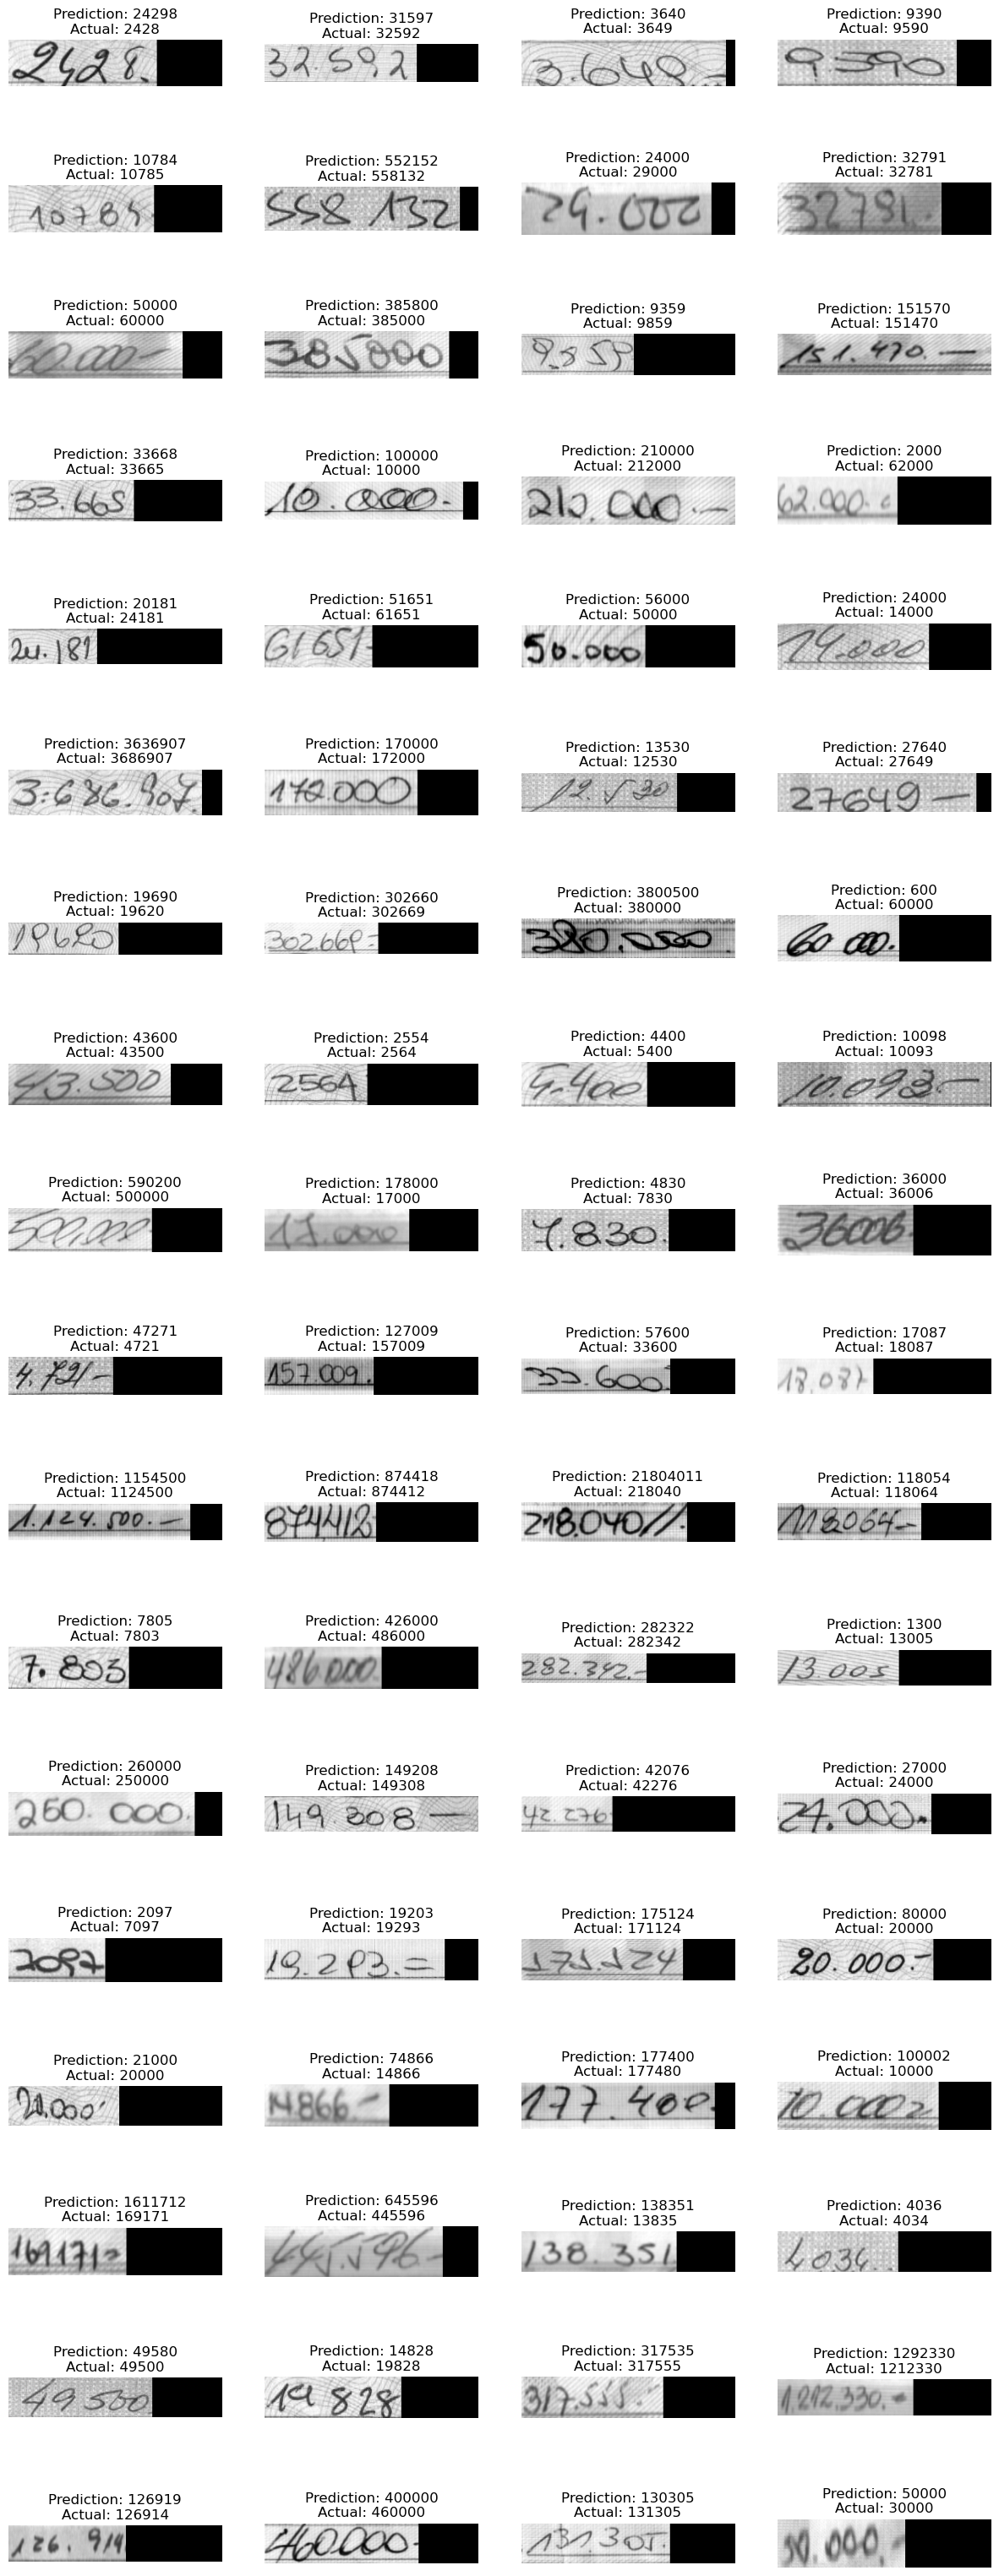

In [26]:
_, ax = plt.subplots(18, 4, figsize=(15, 40))
for i in range(len(misclassified_images)):
    img, orig_text, pred_text = misclassified_images[i]
    img = (img[:, :, 0] * 255).numpy().astype(np.uint8)
    img = img.T
    title = f"Prediction: {pred_text}\nActual: {orig_text}"
    ax[i // 4, i % 4].imshow(img, cmap="gray")
    ax[i // 4, i % 4].set_title(title)
    ax[i // 4, i % 4].axis("off")
plt.show()

Accuracy & Character error rate

In [27]:
def calculate_cer(y_true, y_pred):
    sum_distance = 0
    sum_length = 0
    for true_seq, pred_seq in zip(y_true, y_pred):
        sum_distance = sum_distance + editdistance.eval(true_seq, pred_seq)
        sum_length = sum_length + len(true_seq)
    return sum_distance / sum_length

In [28]:
def calculate_acc(y_true, y_pred):
  acc = np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true)
  return acc

In [29]:
calculate_cer(orig_list, pred_list)

0.013164472587902017

In [30]:
calculate_acc(orig_list, pred_list)

0.9385665529010239

Save Weights of Model

In [ ]:
model.save_weights('weight.h5')

Load Model of one character input

In [66]:
model2 = keras.models.Sequential()
model2.add(layers.Input((28,28,1)))
model2.add(layers.Conv2D(32,kernel_size=3,padding='same',activation='relu'))
model2.add(layers.BatchNormalization())
model2.add(layers.Conv2D(32,kernel_size=3,padding='same',activation='relu'))
model2.add(layers.BatchNormalization())
model2.add(layers.Conv2D(32,kernel_size=5,strides=2,padding='same',activation='relu'))
model2.add(layers.BatchNormalization())
model2.add(layers.Dropout(0.4))

model2.add(layers.Conv2D(64,kernel_size=3,padding='same',activation='relu'))
model2.add(layers.BatchNormalization())
model2.add(layers.Conv2D(64,kernel_size=3,padding='same',activation='relu'))
model2.add(layers.BatchNormalization())
model2.add(layers.Conv2D(64,kernel_size=5,strides=2,padding='same',activation='relu'))
model2.add(layers.BatchNormalization())
model2.add(layers.Dropout(0.4))

model2.add(layers.Flatten())
model2.add(layers.Dense(128, activation='relu'))
model2.add(layers.Dropout(0.4))
model2.add(layers.Dense(10, activation='softmax'))

In [67]:
model2.load_weights('/content/weight_single_input.h5')

prediction

In [68]:
preds_label = []
for path in x_test:
  number = ""
  # Read the input image (make sure it's a binary image)
  image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

  # Apply thresholding to create a binary image
  _, binary_image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV)

  # Use connectedComponentsWithStats to obtain labels and bounding boxes
  num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_image, connectivity=4)

  x_y = []   # List to store coordinates of bounding boxes
  number_images = []   # List to store images of connected components

  # Iterate through each connected component
  for label in range(1, num_labels):#num_labels
    # Get the bounding box of the current connected component
    x, y, w, h = stats[label][:4]

    # Crop the connected component using the bounding box
    connected_component = np.uint8(binary_image[y:y+h, x:x+w])
    x_y.append((x, y))
    number_images.append(connected_component)

  # If no connected components are found (only background), append an empty number
  if num_labels == 1:
    preds_label.append(number)
  else:
    # Combine coordinates and images, then sort them based on the x-coordinate (left to right)
    combined = list(zip(x_y, number_images))
    sorted_combined = sorted(combined, key=lambda x: x[0][0])
    x_y, number_images = zip(*sorted_combined)
    for img, loc in zip(number_images, x_y):
      # Process the image only if its dimensions are significant
      if img.shape[0] > 8 and img.shape[1] > 8:
          img = img.astype('float32') / 255
          # Add padding to the image
          img = cv2.copyMakeBorder(img, 5,5,5,5,cv2.BORDER_CONSTANT,value=0)
          new_img = cv2.resize(img, dsize=(28, 28))
          new_img = np.expand_dims(new_img, axis=2) # Add channel dimension
          new_img = np.expand_dims(new_img, axis=0) # Add batch dimension
          # Predict the digit using the model and append to the number string
          number = number + str(np.argmax(model2.predict(new_img, verbose=0)))
    preds_label.append(number)

In [69]:
calculate_cer(y_test, preds_label)

0.5999000166638894

In [70]:
calculate_acc(y_test, preds_label)

0.07679180887372014

Comparison and reasons for the superiority of RNN model with CTC cost function

1. Reducing complexity:
 - In the first method, we need several steps of image processing to separate the characters, which can increase the complexity and processing time.
 - In the second method, the RNN model directly converts the input image into a sequence of characters, and there is no need for complicated steps to separate the characters.

2. Higher accuracy:
 - In the first method, the accuracy of character recognition depends on the quality of the image processing steps and character separation. Errors in these steps can reduce the overall accuracy of the system.
 - In the second method, the RNN model is trained end-to-end and there are no errors related to character separation. This increases the overall accuracy of the system.

3. Resistance to changes and noise:
 - The RNN model using the CTC cost function can adapt well to various noises and changes in the image, while image processing methods may have problems in dealing with the changes and noises.

4. Ease of implementation:
 - RNN models with CTC cost function are relatively simpler to implement and maintain, as there is no need for complex settings for image processing steps.

In this dataset, due to the sticking of digits in a number of images and the creation of noise when converting to binary images, using the image processing method is not optimal and good accuracy is not obtained.